# Fig. 5. Association of antidepressants meta-analytic effects and transcranial magnetic stimulation targets

In [1]:
# set_env.py is not included in the repo
# it defines $HCP_DENSE_PATH, $PROJECT_DIR (required) and $HCP_DIR (optional)
# in environment variables
import set_env

In [3]:
import os
import sys
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import neuromaps.transforms
import nibabel
import nilearn.image, nilearn.surface
import pyvirtualdisplay
from matplotlib.colors import LinearSegmentedColormap
import statsmodels.stats.multitest
import surfplot

# create virtual display for plotting meshes in remote servers
disp=pyvirtualdisplay.Display(visible=False)
disp.start()

sys.path.append('../scripts')
from helpers import io, transform, plot, stats

plt.rcParams.update({"font.size": 12, "font.family": "Asana Math", "figure.dpi": 192})

## A. Location of TMS targets in comparison to DLPFC convergent cluster

Distance of center coordinate and TMS targets:

In [4]:
all_tms_coords = {
    '5-CM': np.array([[-41, 16, 54]]),
    'Beam F3': np.array([[-41, 42, 34]]),
    'Anti-subgenual': np.array([[-38, 44, 26]]),
}
cluster_center = np.array([[-38, 30, 28]])
distances = {}
for k, v in all_tms_coords.items():
    distances[k] = np.linalg.norm(cluster_center - v)
distances

{'5-CM': 29.68164415931166,
 'Beam F3': 13.74772708486752,
 'Anti-subgenual': 14.142135623730951}

Plot cluster extent vs TMS target coordinates on cortical surface:

In [5]:
cluster_nifti = os.path.join(io.RESULTS_DIR, 'ale', 'Contrast', 
                             'Results', 'MainEffect', 'Full', 'Volumes', 'Corrected',
                             'Contrast_increased_cFWE05.nii')
cluster_fslr = neuromaps.transforms.mni152_to_fslr(cluster_nifti, method='nearest')
cluster_fslr = cluster_fslr[0].agg_data()

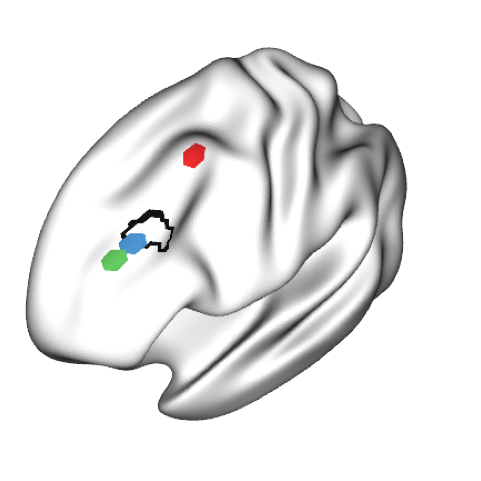

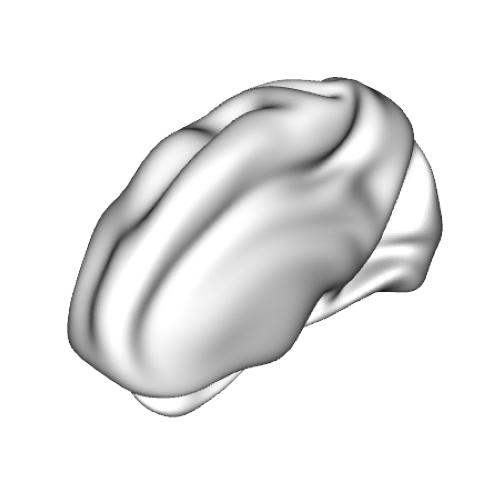

In [6]:
tms_points = {}
tms_fslrs = {}

p = surfplot.Plot(surf_lh=plot.MESHES_FSLR['L'], surf_rh=None, 
                  views=[(45, 60, 105)],
                 size = (200, 200), zoom = 2.1, brightness=1,
                 );
p.add_layer(cluster_fslr>0, cmap='Greys', as_outline=True, cbar=False);
colors = sns.color_palette('Set1', len(all_tms_coords))
all_xyz = transform.get_cifti_mni_coordinates()
lh_mesh = nilearn.surface.load_surf_mesh(plot.MESHES_FSLR['L'])
for i, (k, tms_coords) in enumerate(all_tms_coords.items()):
    # map MNI coordinate to Cifti point
    tms_point = scipy.spatial.distance_matrix(tms_coords, all_xyz).argmin()
    # create an fsLR map of the center point
    tms_cifti = np.zeros(transform.CIFTI_NPOINTS)
    tms_cifti[tms_point] = 1
    tms_fslr = transform.cifti_to_fsLR(tms_cifti, concat=False)['L']
    # extend it to neighboring vertices for better visibility
    rounds = 3
    for _ in range(rounds):
        boundary_faces = tms_fslr[lh_mesh.faces].sum(axis=1) >= 1
        tms_fslr[lh_mesh.faces[boundary_faces].flatten()] = 1
    tms_points[k] = tms_point
    tms_fslrs[k] = tms_fslr
    curr_cmap = LinearSegmentedColormap.from_list(
        'curr_cmap', 
        [colors[i], (1, 1, 1, 0.5)]
    )
    p.add_layer(tms_fslr, cmap=curr_cmap, cbar=False, as_outline=False);
p.build();

# plot empty right hemisphere
# the two hemispheres were positioned next to each other
# manually in the figure
p_rh = surfplot.Plot(surf_lh=None, surf_rh=plot.MESHES_FSLR['R'], 
                  views=[(45, -60, -105)],
                 size = (200, 200), zoom = 2.1, brightness=1,
                 );
p_rh.build();

(0.0, 1.0, 0.0, 1.0)

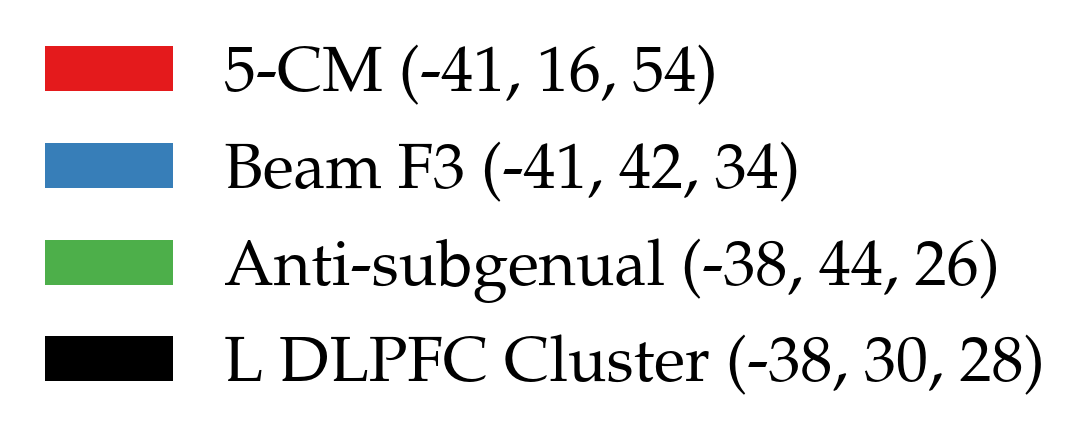

In [7]:
from matplotlib.patches import Patch
colors = sns.color_palette('Set1', len(all_tms_coords))
keys = [f'{k} ({v[0,0]}, {v[0,1]}, {v[0,2]})' for k, v in all_tms_coords.items()]
colors = dict(zip(keys, colors))
colors[f'L DLPFC Cluster ({cluster_center[0,0]}, {cluster_center[0,1]}, {cluster_center[0,2]})'] = (0, 0, 0)
legend_handles = [
    Patch(facecolor=colors[label], edgecolor="none", label=label) for label in colors
]
plt.figure(figsize=(4, 2))
plt.legend(handles=legend_handles, fontsize="24", loc="center", frameon=False)
plt.axis("off")

## B. Comparison of circuits

### Maps

Load and plot RSFC of the grayordinate representing each target:

In [8]:
dconn = nibabel.load(os.environ['HCP_DENSE_PATH'])

pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


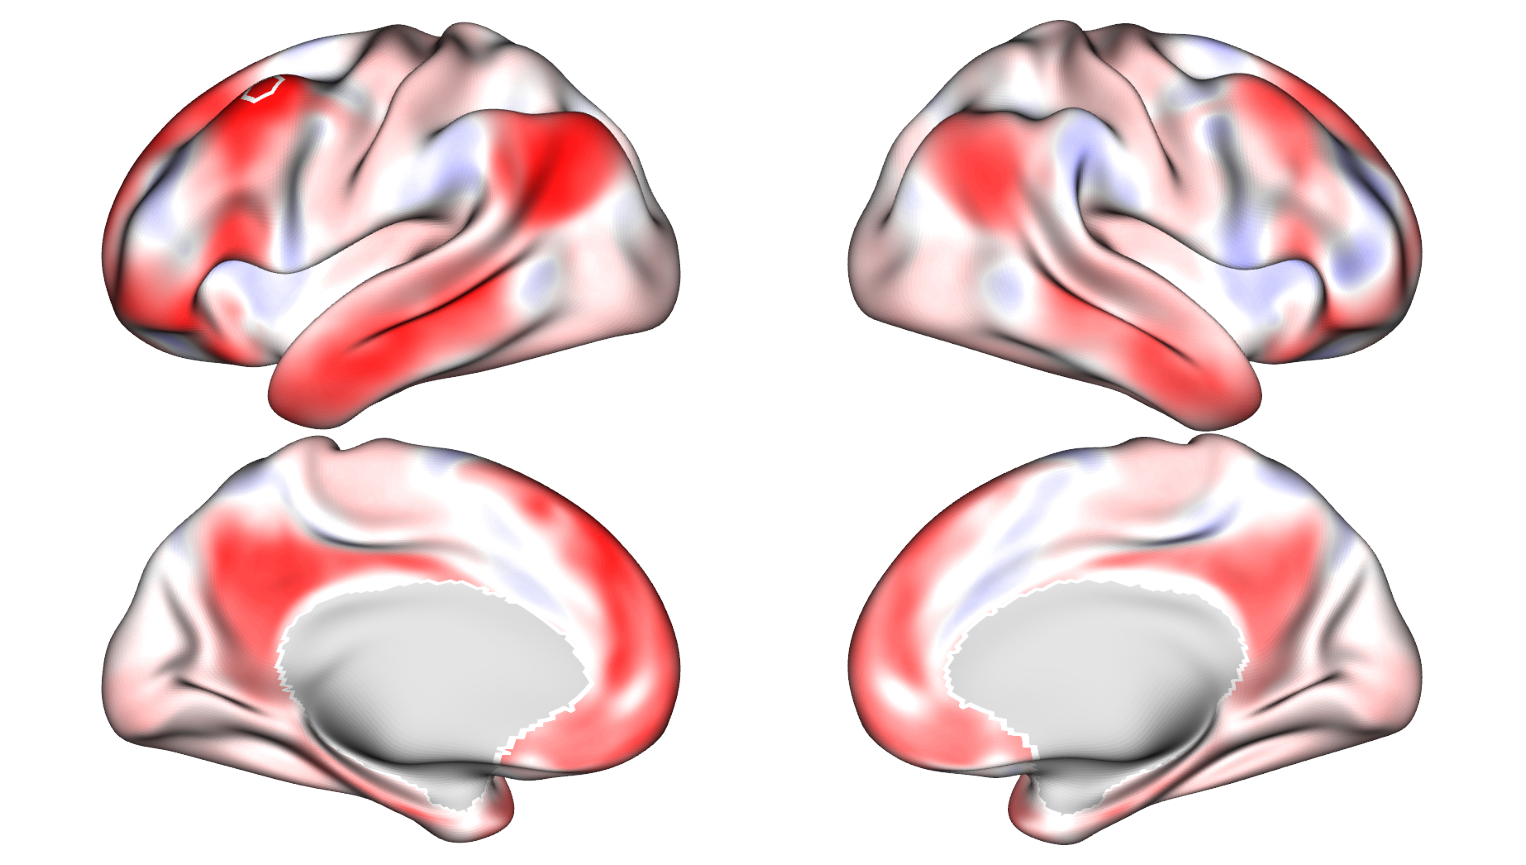

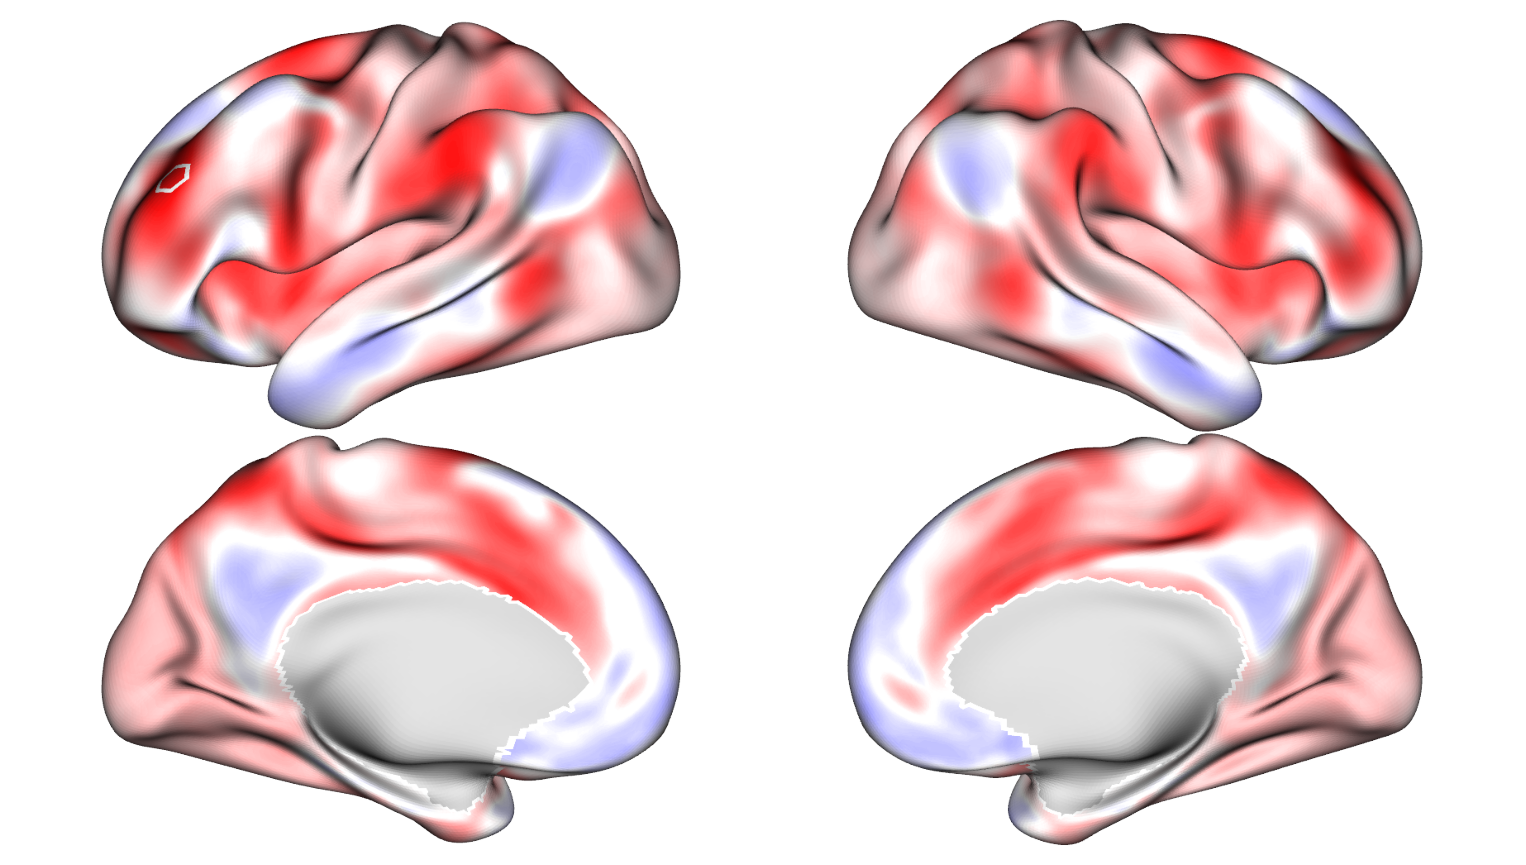

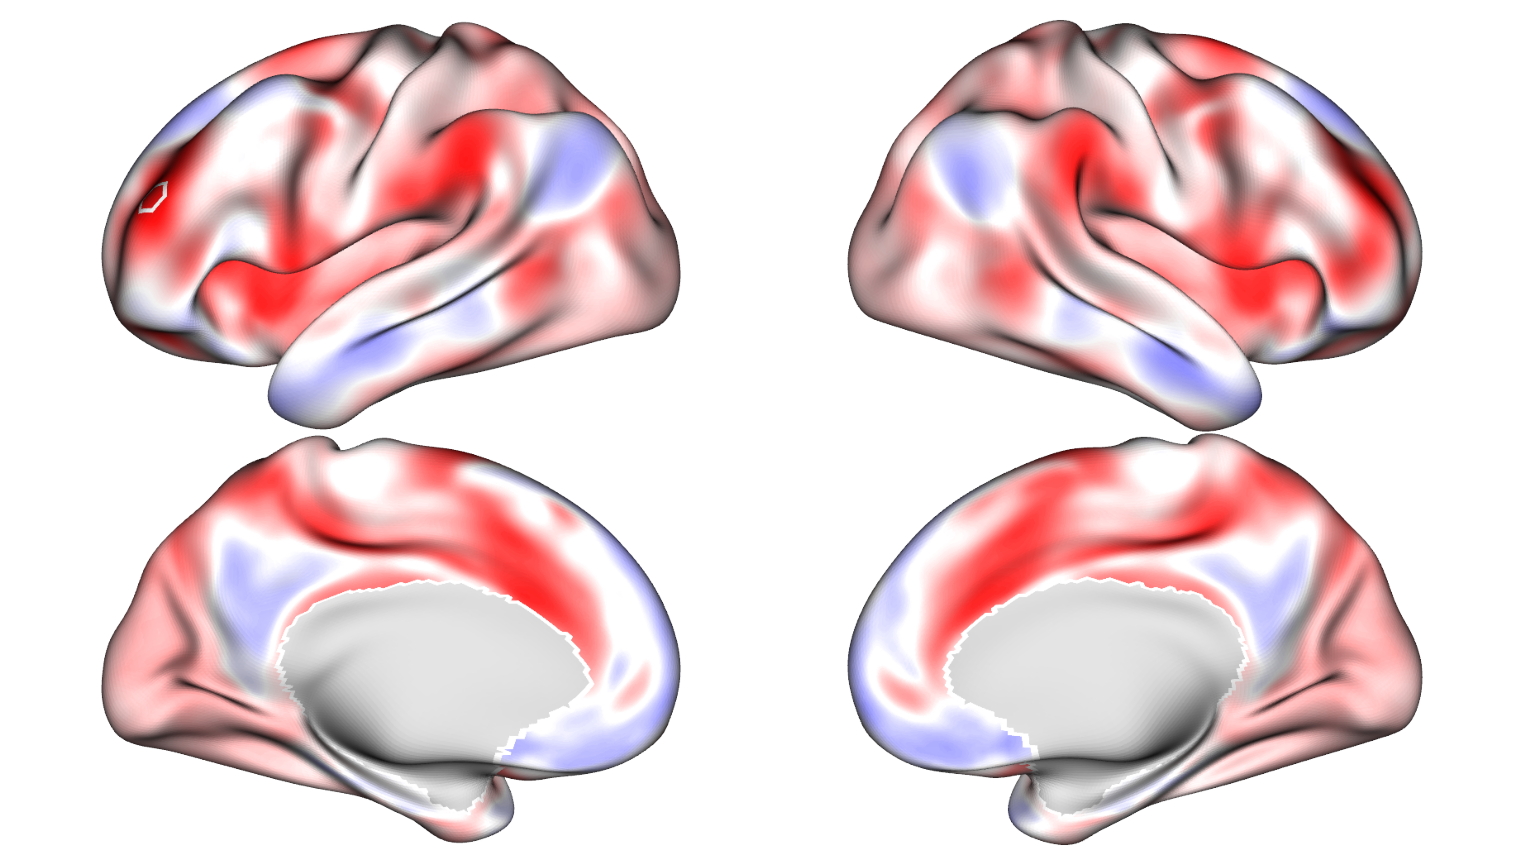

In [9]:
conn_fslrs = {}
conn_ciftis = {}
for k in tms_points.keys():
    conn = np.tanh(dconn.dataobj[:, tms_points[k]]) # tanh for Z to r transformation
    conn_ciftis[k] = conn
    conn_fslr = transform.cifti_to_fsLR(conn)
    conn_fslrs[k] = conn_fslr
    tms_fslr = np.concatenate([tms_fslrs[k], np.zeros_like(tms_fslrs[k])])
    p = surfplot.Plot(surf_lh=plot.MESHES_FSLR['L'], surf_rh=plot.MESHES_FSLR['R'], 
                     layout='grid', size = (900, 500), zoom = 1.8, brightness=1, mirror_views=True,
                     );
    p.add_layer(conn_fslr, cmap='seismic_light', cbar=False, color_range=(-1,1));
    p.add_layer(tms_fslr, cmap='Greys_r', as_outline=True, cbar=False);
    p.add_layer(~transform.FSLR_CORTEX, cmap='Greys_r', cbar=False, color_range=(0, 1.5))
    p.build()

/tmp/ipykernel_115877/3408581630.py:1: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  conn_parc = transform.parcellate_cifti(np.vstack(conn_ciftis.values()), schaefer='400', tian='S2')
/data/group/cng/Projects/Amin/antidepressants_ale/public/scripts/figures/../helpers/plot.py:172: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Right Hippocampus' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  tian_to_mesh.loc[label] = f'{hem} {abbr_to_full[key]}'
/data/group/cng/Projects/Amin/antidepressants_ale/venv/lib/python3.11/site-packages/brainspace/plotting/base.py:287: UserWarning: Interactive mode requires 'panel'. Setting 'interactive=False'
  warnings.warn("Interactive mode requires 'panel'. "


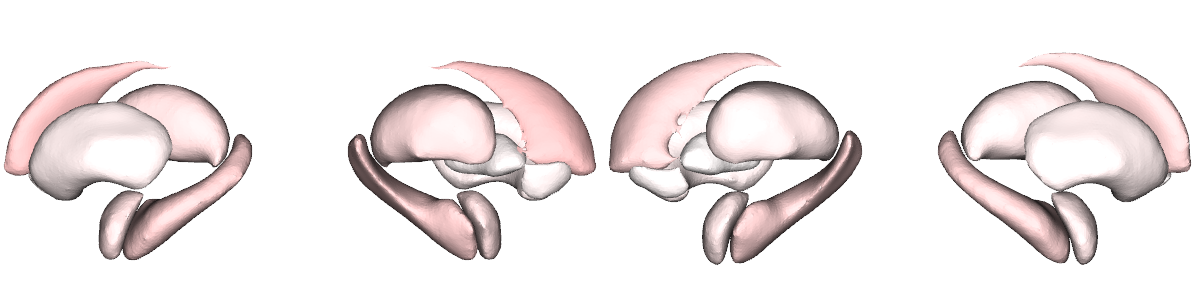

/data/group/cng/Projects/Amin/antidepressants_ale/public/scripts/figures/../helpers/plot.py:172: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Right Hippocampus' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  tian_to_mesh.loc[label] = f'{hem} {abbr_to_full[key]}'
/data/group/cng/Projects/Amin/antidepressants_ale/venv/lib/python3.11/site-packages/brainspace/plotting/base.py:287: UserWarning: Interactive mode requires 'panel'. Setting 'interactive=False'
  warnings.warn("Interactive mode requires 'panel'. "


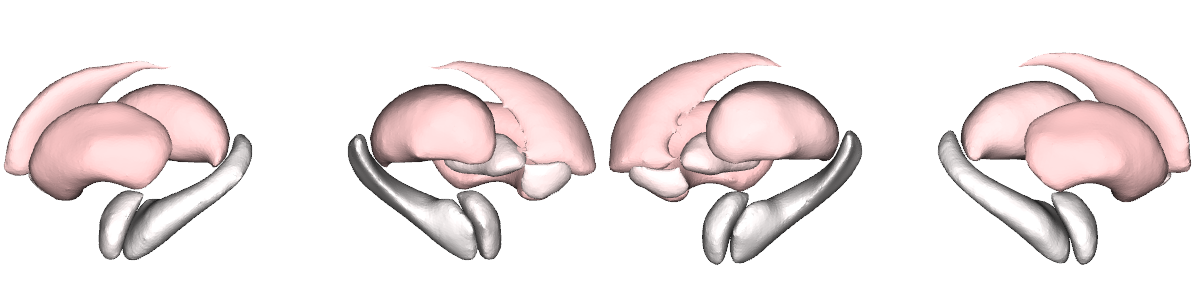

/data/group/cng/Projects/Amin/antidepressants_ale/public/scripts/figures/../helpers/plot.py:172: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Right Hippocampus' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  tian_to_mesh.loc[label] = f'{hem} {abbr_to_full[key]}'
/data/group/cng/Projects/Amin/antidepressants_ale/venv/lib/python3.11/site-packages/brainspace/plotting/base.py:287: UserWarning: Interactive mode requires 'panel'. Setting 'interactive=False'
  warnings.warn("Interactive mode requires 'panel'. "


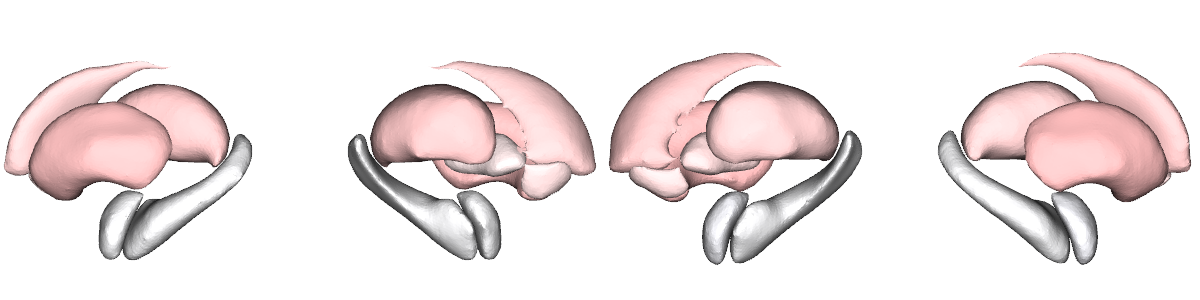

In [10]:
conn_parc = transform.parcellate_cifti(np.vstack(conn_ciftis.values()), schaefer='400', tian='S2')
conn_parc.columns = conn_ciftis.keys()
for k in conn_parc.columns:
    display(plot.plot_parc_subcortical(conn_parc.loc[:, k], cmap='seismic_light', zoom=1.4, color_range=(-1, 1)))

Plot Tr+ cluster connectivity:

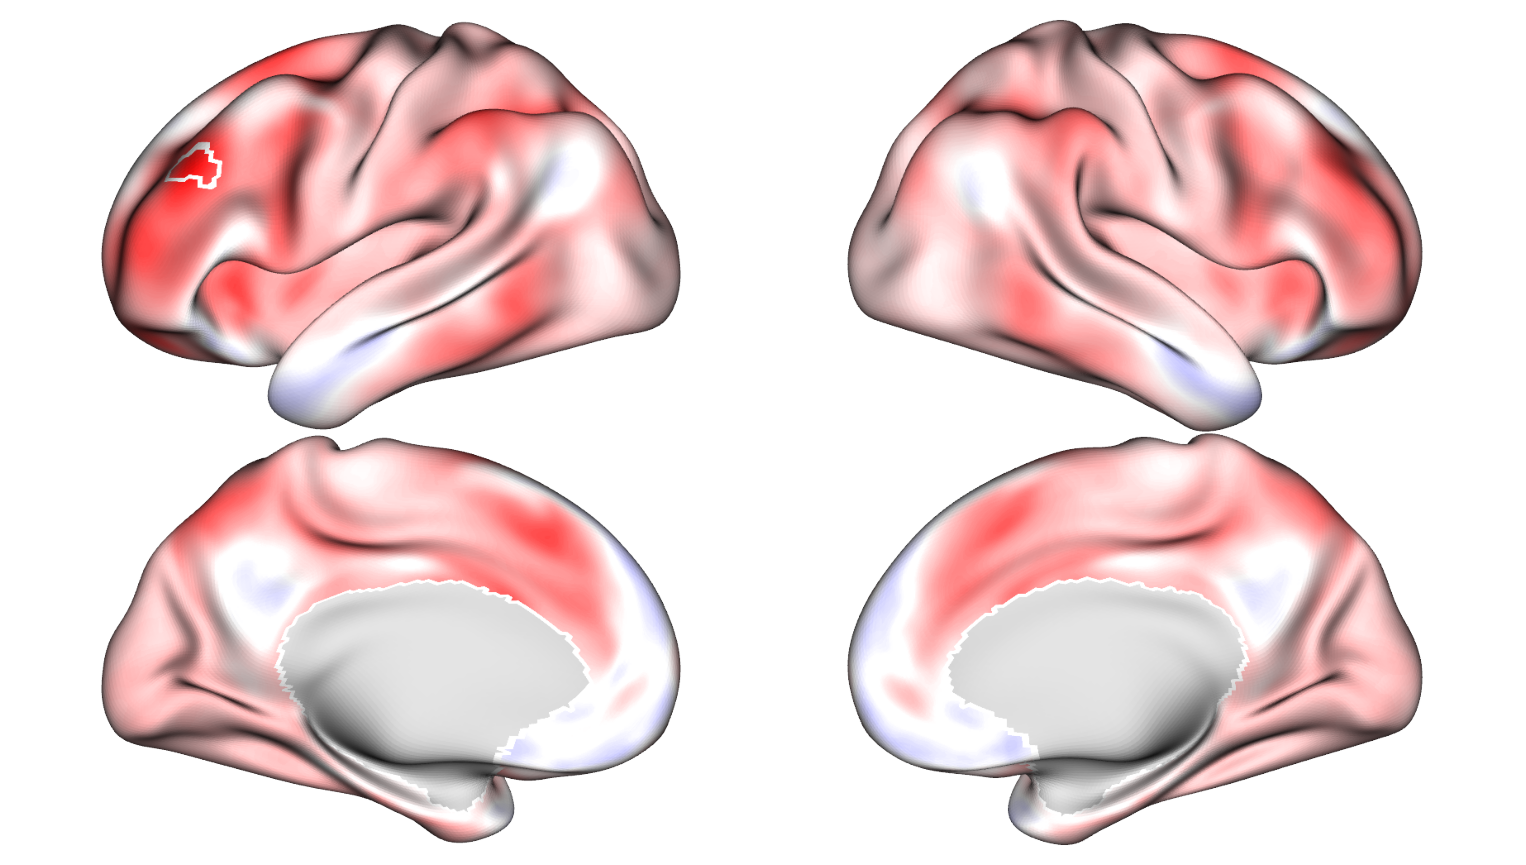

In [16]:
cl_conn_fslr = np.load(os.path.join(io.RESULTS_DIR, 'rsfc', 'Contrast_increased_cFWE05', 'cl_conn_mean_fslr.npy'))
p = surfplot.Plot(surf_lh=plot.MESHES_FSLR['L'], surf_rh=plot.MESHES_FSLR['R'], 
                 layout='grid', size = (900, 500), zoom = 1.8, brightness=1, mirror_views=True,
                 )
p.add_layer(cl_conn_fslr, cmap='seismic_light', cbar=False, color_range=(-1,1));
p.add_layer(np.concatenate([cluster_fslr>0, np.zeros_like(cluster_fslr)]), cmap='Greys_r', as_outline=True, cbar=False);
p.add_layer(~transform.FSLR_CORTEX, cmap='Greys_r', cbar=False, color_range=(0, 1.5));
p.build();

/data/group/cng/Projects/Amin/antidepressants_ale/public/scripts/figures/../helpers/plot.py:172: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Right Hippocampus' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  tian_to_mesh.loc[label] = f'{hem} {abbr_to_full[key]}'
/data/group/cng/Projects/Amin/antidepressants_ale/venv/lib/python3.11/site-packages/brainspace/plotting/base.py:287: UserWarning: Interactive mode requires 'panel'. Setting 'interactive=False'
  warnings.warn("Interactive mode requires 'panel'. "


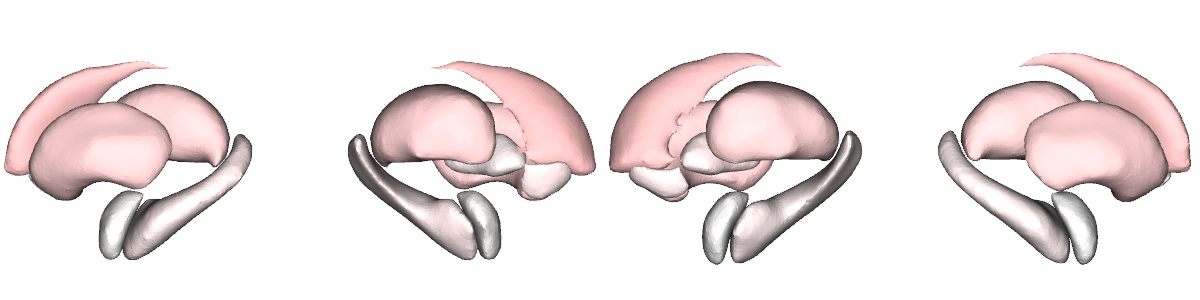

In [17]:
cl_conn = np.load(os.path.join(io.RESULTS_DIR, 'rsfc', 'Contrast_increased_cFWE05', 'cl_conn_mean_cifti.npy'))
cl_conn_parc = transform.parcellate_cifti(cl_conn, schaefer='400', tian='S2')
cl_conn_parc.columns = ['L DLPFC RSFC']

plot.plot_parc_subcortical(cl_conn_parc.iloc[:, 0], cmap='seismic_light', zoom=1.4, color_range=(-1, 1))

Plot convergent connectivity map:

-3.0905291379252677 3.0905291379252677


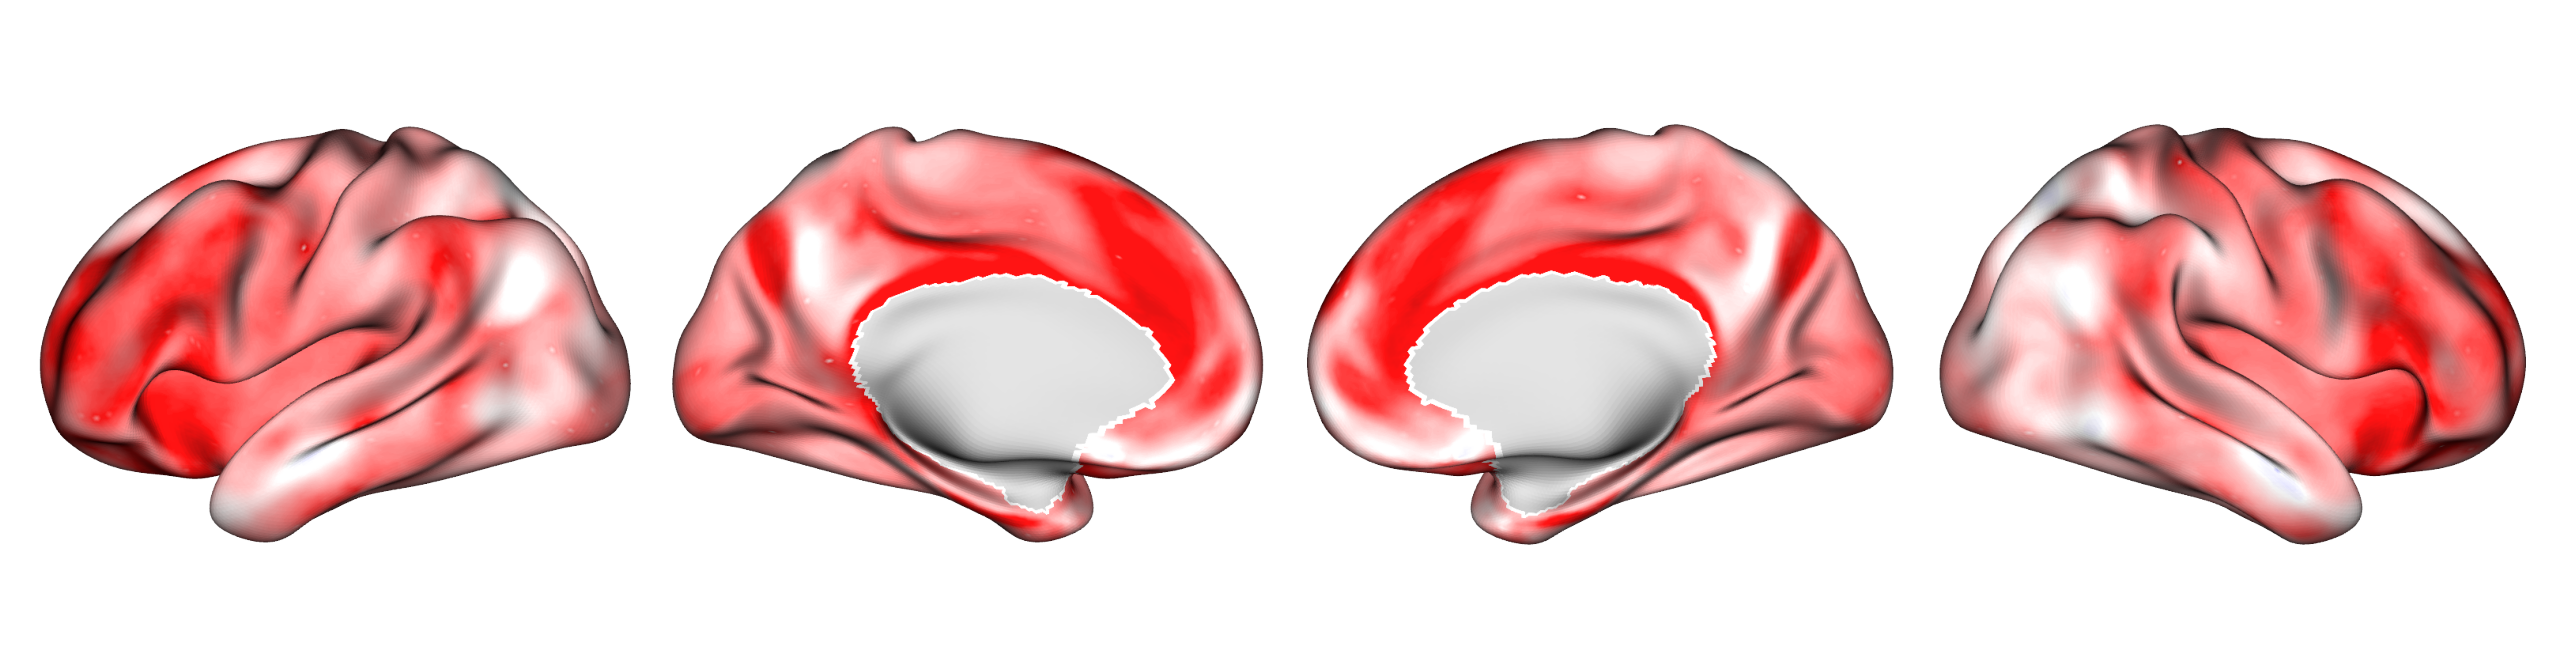

In [18]:
ccm = np.load(os.path.join(io.RESULTS_DIR, 'ccm', 'ccm_random_weighted_n-1000', 'All', 'zmap.npy'))
ccm_fslr = transform.cifti_to_fsLR(ccm)
p = surfplot.Plot(surf_lh=plot.MESHES_FSLR['L'], surf_rh=plot.MESHES_FSLR['R'], 
                  layout='row', size=(1600, 400), zoom=1.2,
                  brightness=1, mirror_views=True,
                 );
vmin = min(np.nanmin(ccm), -np.nanmax(ccm))
vmax = -vmin
print(vmin, vmax)
p.add_layer(ccm_fslr, cmap='seismic_light', cbar=False, color_range=(vmin,vmax));
p.add_layer(~transform.FSLR_CORTEX, cmap='Greys_r', cbar=False, color_range=(0, 1.5));
p.build();

/data/group/cng/Projects/Amin/antidepressants_ale/public/scripts/figures/../helpers/plot.py:172: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Right Hippocampus' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  tian_to_mesh.loc[label] = f'{hem} {abbr_to_full[key]}'
/data/group/cng/Projects/Amin/antidepressants_ale/venv/lib/python3.11/site-packages/brainspace/plotting/base.py:287: UserWarning: Interactive mode requires 'panel'. Setting 'interactive=False'
  warnings.warn("Interactive mode requires 'panel'. "


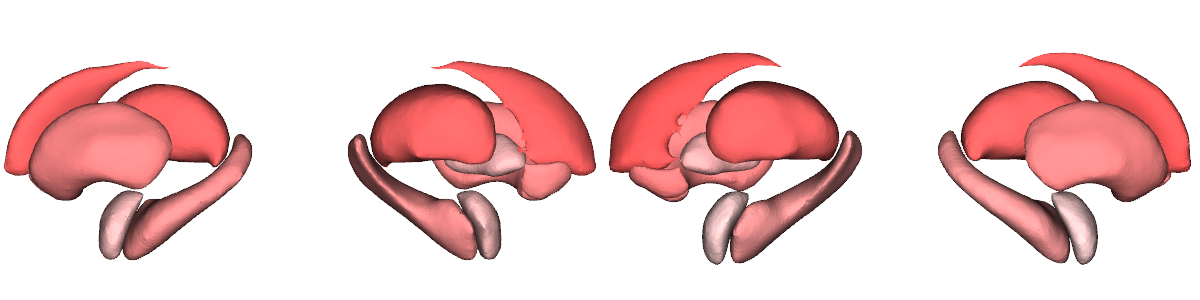

In [19]:
ccm_parc = transform.parcellate_cifti(ccm, schaefer='400', tian='S2')
ccm_parc.columns = ['CCM']

plot.plot_parc_subcortical(ccm_parc.iloc[:, 0], cmap='seismic_light', zoom=1.4, color_range=(vmin, vmax))

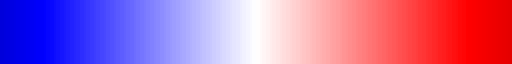

In [23]:
sns.color_palette('seismic_light', as_cmap=True)

### Correlation heatmap

Parcellate the maps:

In [20]:
# concatenate all parcellated maps
maps_parc = pd.concat([conn_parc, ccm_parc, cl_conn_parc], axis=1)

Calculate cross-correlation of all maps:

In [21]:
# calculate correlation of the maps while correcting for SA using variograms
coefs, pvals, _ = stats.variogram_test(
    maps_parc, 
    maps_parc,
    n_perm=1000, 
    surrogates_path='./tmsconn_ccm_clconn_schaefer-400_tian-S2_n-1000_variograms.npz'
)

# reorder
order = list(coefs.columns[:3]) + ['L DLPFC RSFC', 'CCM']
coefs = coefs.loc[order, order]
pvals = pvals.loc[order, order]

Surrogates already exist in ./tmsconn_ccm_clconn_schaefer-400_tian-S2_n-1000_variograms.npz


Drop upper triangular part of the correlation matrix and apply FDR correction:

In [22]:
coefs.values[np.triu_indices_from(coefs)] = np.NaN
pvals.values[np.triu_indices_from(pvals)] = np.NaN

pvals_fdr = pvals.copy()
_, pvals_fdr.values[np.tril_indices_from(pvals_fdr, -1)] = statsmodels.stats.multitest.fdrcorrection(
    pvals.values[np.tril_indices_from(pvals, -1)]
)

In [23]:
coefs

5-CM   Beam F3  Anti-subgenual  L DLPFC RSFC  CCM
5-CM                 NaN       NaN             NaN           NaN  NaN
Beam F3        -0.819287       NaN             NaN           NaN  NaN
Anti-subgenual -0.819611  0.952953             NaN           NaN  NaN
L DLPFC RSFC   -0.496481  0.818048        0.722184           NaN  NaN
CCM            -0.018146  0.178203        0.306654      0.322341  NaN

In [24]:
pvals

5-CM   Beam F3  Anti-subgenual  L DLPFC RSFC  CCM
5-CM                 NaN       NaN             NaN           NaN  NaN
Beam F3         0.000999       NaN             NaN           NaN  NaN
Anti-subgenual  0.000999  0.000999             NaN           NaN  NaN
L DLPFC RSFC    0.000999  0.000999        0.000999           NaN  NaN
CCM             0.815185  0.057942        0.000999      0.000999  NaN

In [25]:
pvals_fdr

5-CM   Beam F3  Anti-subgenual  L DLPFC RSFC  CCM
5-CM                 NaN       NaN             NaN           NaN  NaN
Beam F3         0.001249       NaN             NaN           NaN  NaN
Anti-subgenual  0.001249  0.001249             NaN           NaN  NaN
L DLPFC RSFC    0.001249  0.001249        0.001249           NaN  NaN
CCM             0.815185  0.064380        0.001249      0.001249  NaN

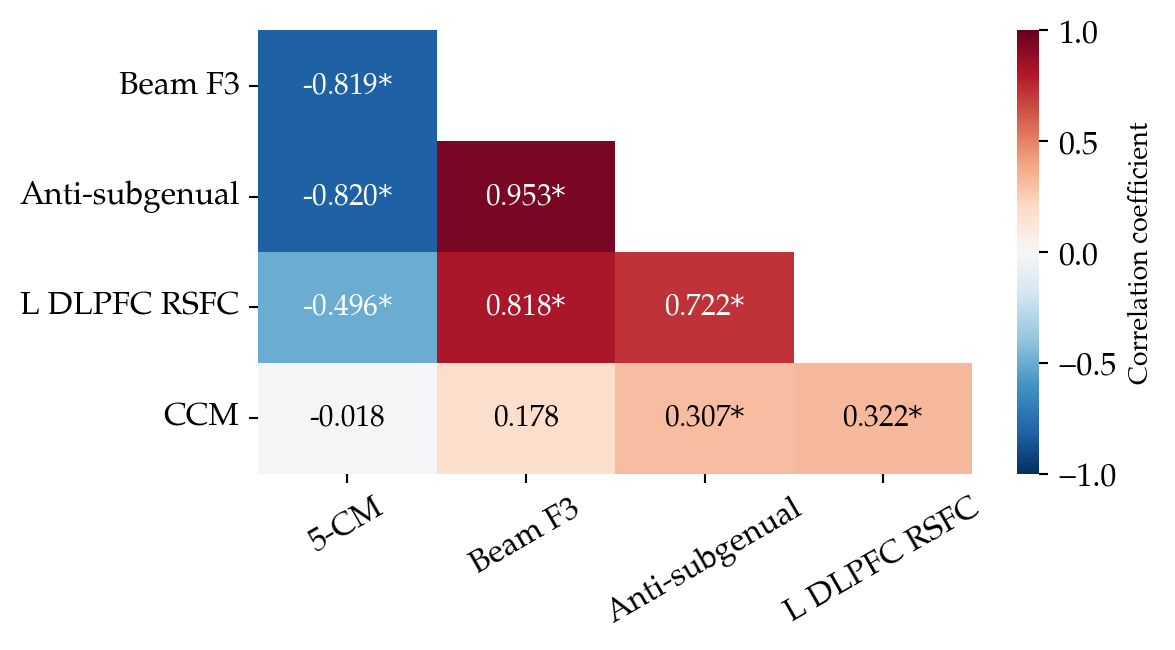

In [26]:
coefs = coefs.dropna(axis=0, how='all').dropna(axis=1, how='all')
pvals_fdr = pvals_fdr.dropna(axis=0, how='all').dropna(axis=1, how='all')

fig, ax = plt.subplots(figsize=(6, 3))
heatmap = sns.heatmap(coefs, cmap='RdBu_r',linecolor='.8', ax=ax, vmin=-1, vmax=1)
heatmap.collections[0].colorbar.set_label('Correlation coefficient', fontsize=10)
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)

# add the text layer
for x, col in enumerate(coefs.columns):
    for y, row in enumerate(coefs.index):
        if x<=y:
            text = f'{coefs.loc[row, col]:.3f}'
            if pvals_fdr.loc[row, col] < 0.05:
                text += '$*$'
            if abs(coefs.loc[row, col]) < 0.4:
                color = 'black'
            else:
                color = 'white'
            ax.text(x+0.5, y+0.5,
                    text, 
                    fontsize=11,
                    color=color,
                    horizontalalignment='center', 
                    verticalalignment='center')